In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc

from imblearn.over_sampling import SMOTE

import xgboost as xgb

from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack


In [2]:
X, y = make_classification(
    n_samples=6000,
    n_features=6,
    n_informative=4,
    n_redundant=2,
    weights=[0.93, 0.07],
    random_state=42
)

text_data = np.where(y == 1, "critical system failure detected", "system running normally")

data = pd.DataFrame(X, columns=[f"feature_{i}" for i in range(6)])
data["text"] = text_data
data["target"] = y

data.head()


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,text,target
0,-0.262851,0.220048,1.322162,-1.605152,0.070843,-1.430447,system running normally,0
1,1.016943,0.164497,0.337649,-1.140235,1.310525,-0.893147,system running normally,0
2,-4.186195,-0.034039,3.236858,-0.204616,-1.678243,-0.780753,system running normally,0
3,1.485169,0.615692,-2.007255,1.485707,-2.852997,-0.467283,system running normally,0
4,-1.350164,0.346494,1.558343,-0.834152,-1.655195,-1.516672,system running normally,0


In [3]:
data["target"].value_counts()

target
0    5548
1     452
Name: count, dtype: int64

In [4]:
X = data.drop(columns=["target", "text"])
y = data["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,
    random_state=42
)


In [5]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

lr_preds = lr.predict(X_test)
lr_probs = lr.predict_proba(X_test)[:, 1]

print(classification_report(y_test, lr_preds))
roc_auc_score(y_test, lr_probs)


              precision    recall  f1-score   support

           0       0.93      1.00      0.96      1664
           1       0.67      0.01      0.03       136

    accuracy                           0.93      1800
   macro avg       0.80      0.51      0.49      1800
weighted avg       0.91      0.93      0.89      1800



0.7351792279411764

In [6]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

pd.Series(y_resampled).value_counts()


target
0    3884
1    3884
Name: count, dtype: int64

In [7]:
xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    scale_pos_weight=13,
    eval_metric="logloss",
    random_state=42
)

xgb_model.fit(X_resampled, y_resampled)

xgb_probs = xgb_model.predict_proba(X_test)[:, 1]


In [8]:
precision, recall, _ = precision_recall_curve(y_test, xgb_probs)
pr_auc = auc(recall, precision)
roc_auc = roc_auc_score(y_test, xgb_probs)

pr_auc, roc_auc


(0.8446487964387531, 0.9461255656108597)

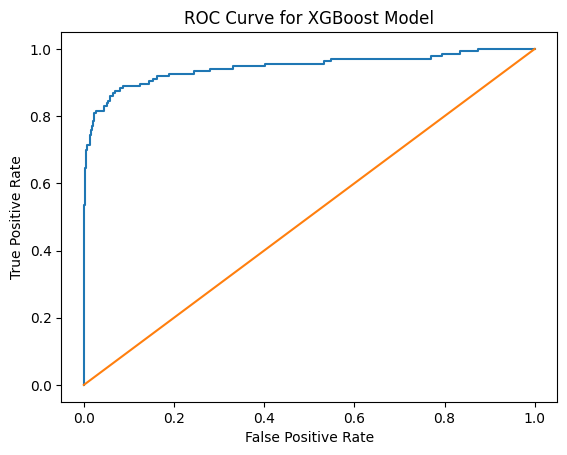

In [12]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, xgb_probs)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for XGBoost Model")
plt.show()


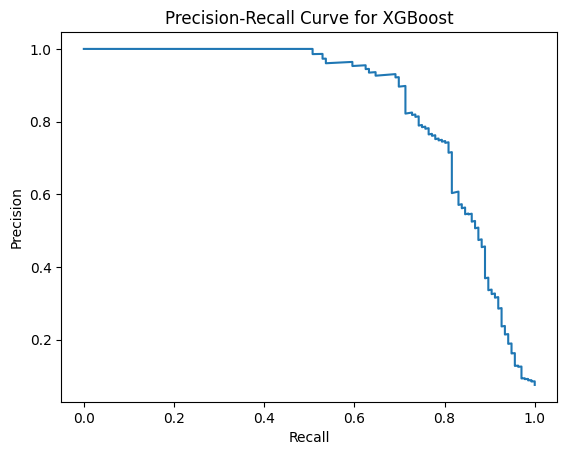

In [9]:
plt.figure()
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for XGBoost")
plt.show()


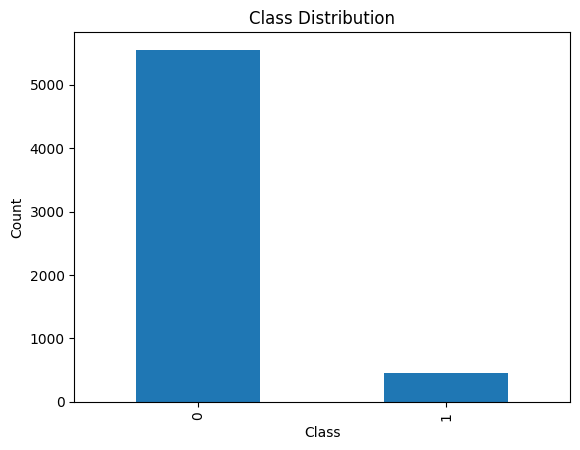

In [13]:
data["target"].value_counts().plot(kind="bar")
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Distribution")
plt.show()


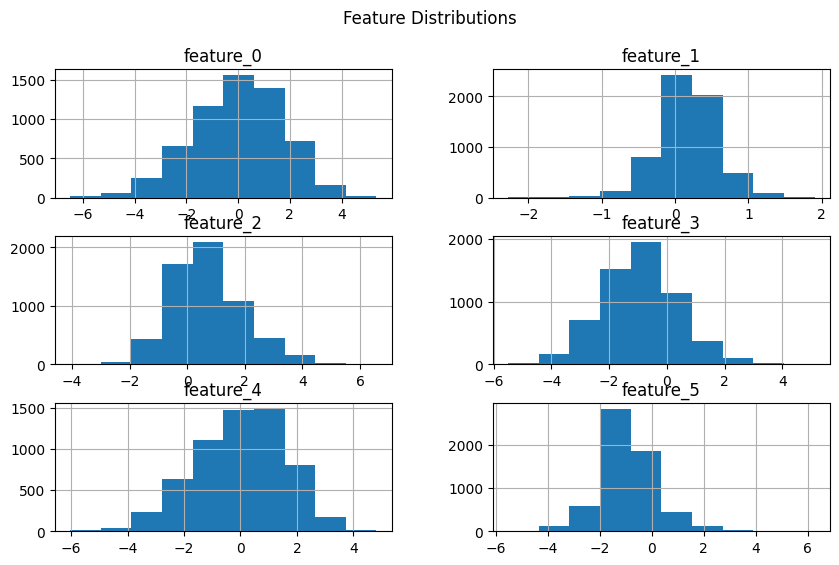

In [14]:
data.drop(columns=["target", "text"]).hist(figsize=(10, 6))
plt.suptitle("Feature Distributions")
plt.show()


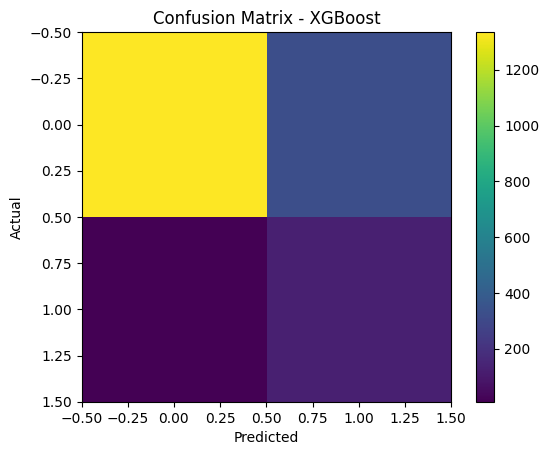

In [15]:
from sklearn.metrics import confusion_matrix

xgb_preds = (xgb_probs >= 0.5).astype(int)
cm = confusion_matrix(y_test, xgb_preds)

plt.figure()
plt.imshow(cm)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBoost")
plt.colorbar()
plt.show()


In [10]:
tfidf = TfidfVectorizer(max_features=30)
text_features = tfidf.fit_transform(data["text"])

numeric_features = data.drop(columns=["target", "text"]).values
combined_features = hstack([numeric_features, text_features])


In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    combined_features,
    data["target"],
    test_size=0.3,
    stratify=data["target"],
    random_state=42
)

xgb_model.fit(X_train, y_train)

final_probs = xgb_model.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, final_probs)


1.0